In [1]:

import tensorflow as tf
import tensorflow_datasets as tfds
import platform
import numpy as np
import random
random.seed(23)
import time
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras as kr

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.10
Tensorflow version: 2.5.0
Keras version: 2.5.0


In [2]:


(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name='rock_paper_scissors',
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
      split=[tfds.Split.TRAIN, tfds.Split.TEST],
)
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [3]:
testRawList=list(map(lambda p: [p[0],p[1]], dataset_test_raw))
trainRawList=list(map(lambda p: [p[0],p[1]], dataset_train_raw))

In [4]:

#funkcje twoezące nowe obrazy zawierające dwie dłonie(x) oraz nowe opisy(y)


def getMerged(imgAndLabel1,imgAndLabel2):
  return np.concatenate((imgAndLabel1[0].numpy(),imgAndLabel2[0].numpy()), axis=1), np.array([imgAndLabel1[1].numpy(),imgAndLabel2[1].numpy()])



def generateXY(dataset,generatedImagesNumber=10 ):
  newX=[]
  newY=[]
  for i in range(generatedImagesNumber):
    img, label=getMerged(dataset[random.randint(1,len(dataset)-1)],dataset[random.randint(1,len(dataset)-1)])
    newX.append(img)
    newY.append(label)
  return np.asarray(newX), np.asarray(newY)
examplesNum=3000
trainX, trainY=generateXY(trainRawList,generatedImagesNumber=int(0.9*examplesNum) )
testX,testY=generateXY(testRawList,generatedImagesNumber=int(0.1*examplesNum) )


Jako że y zapisane jest w formacie dwóch liczby w przedziale [0,2], przekodowuję y na wektor "onehot" gdzie każda pozycja 1 symbolizuje jeden z 9 przypadków wyników gry(z uwzględnieniem stron rąk); 1 na pozycji pierwszej: kamien kamien, 1 na pozycji drugiej papier kamien itd.dzięki czemu mogę wykorzystać podejście klasyfikacji "multiclass"

In [5]:

from keras.utils.np_utils import to_categorical   


trainY=np.asarray(list(map(lambda x: np.resize(to_categorical(x[0]+x[1]*3, num_classes=9),(9)),trainY)))
testY=np.asarray(list(map(lambda x: np.resize(to_categorical(x[0]+x[1]*3, num_classes=9),(9)),testY)))




Przykłady x i y:

[0. 0. 0. 1. 0. 0. 0. 0. 0.]


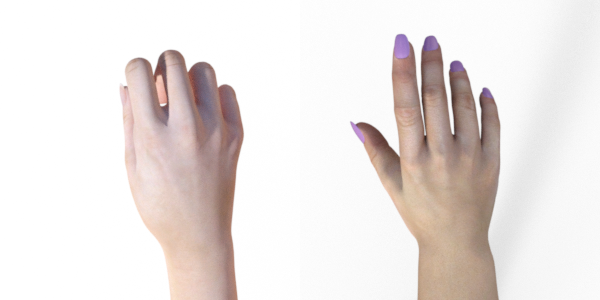

In [6]:
from PIL import Image
import numpy as np

img = Image.fromarray(trainX[22], 'RGB')
print( trainY[22])
img

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


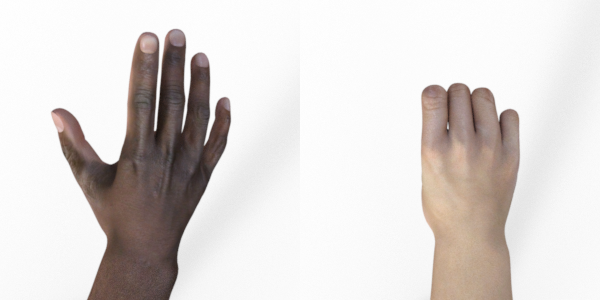

In [7]:
img = Image.fromarray(trainX[23], 'RGB')
print( trainY[23])
img

Zmieniam obrazy na czarno białe i zmniejszam ich wielkość. Takie detale jak kolor paznokci, skóry, zmarszczki nie są związane z pokazywanym symbolem. Może to pomóc zapobiec przetrenowaniu i przyspieszy trening sieci.

In [8]:


def resizeImage(imageNp):
  
  im = Image.fromarray(imageNp, 'RGB')
  im=im.resize((int(imageNp.shape[1]/4),int(imageNp.shape[0]/2))).convert('L')
  return np.array(im)







testX=np.asarray(list(map(lambda x: resizeImage(x), testX)))
trainX=np.asarray(list(map(lambda x: resizeImage(x), trainX)))


[0. 0. 0. 1. 0. 0. 0. 0. 0.]


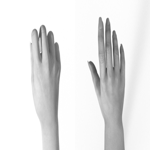

In [9]:
img = Image.fromarray(trainX[22], 'L')
print( trainY[22])
img


[0. 1. 0. 0. 0. 0. 0. 0. 0.]


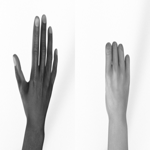

In [10]:
img = Image.fromarray(trainX[23], 'L')
print( trainY[23])
img

[0. 0. 0. 0. 0. 1. 0. 0. 0.]


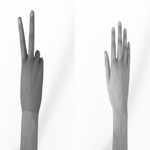

In [11]:
img = Image.fromarray(testX[22], 'L')
print( testY[22])
img

[0. 0. 0. 0. 0. 1. 0. 0. 0.]


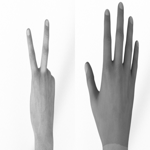

In [12]:
img = Image.fromarray(testX[23], 'L')
print( testY[23])
img

In [13]:
trainX=trainX.reshape(trainX.shape+(1,))/255.0
testX=testX.reshape(testX.shape+(1,))/255.0

print(trainX[0])
print(trainY[0])

print(testX[0])
print(testY[0])

[[[0.99215686]
  [0.99215686]
  [0.99215686]
  ...
  [0.95686275]
  [0.95294118]
  [0.94901961]]

 [[0.99215686]
  [0.99215686]
  [0.99215686]
  ...
  [0.95686275]
  [0.94901961]
  [0.94509804]]

 [[0.99215686]
  [0.99215686]
  [0.99215686]
  ...
  [0.95686275]
  [0.95294118]
  [0.94901961]]

 ...

 [[0.98431373]
  [0.98431373]
  [0.98431373]
  ...
  [0.97647059]
  [0.97647059]
  [0.98039216]]

 [[0.98431373]
  [0.98431373]
  [0.98431373]
  ...
  [0.97647059]
  [0.97647059]
  [0.98039216]]

 [[0.98431373]
  [0.98431373]
  [0.98431373]
  ...
  [0.97647059]
  [0.98039216]
  [0.98039216]]]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[[[0.99607843]
  [0.99215686]
  [0.99215686]
  ...
  [0.98039216]
  [0.98039216]
  [0.97647059]]

 [[0.99607843]
  [0.99215686]
  [0.99215686]
  ...
  [0.98039216]
  [0.98039216]
  [0.97647059]]

 [[0.99607843]
  [0.99215686]
  [0.99215686]
  ...
  [0.98039216]
  [0.98039216]
  [0.97647059]]

 ...

 [[0.98039216]
  [0.97647059]
  [0.97647059]
  ...
  [0.98039216]
  [0.980392

In [14]:
from tensorflow.keras import constraints
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))

print('Test: X=%s, y=%s' % (testX.shape, testY.shape))






regVal=0.001

model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(trainX.shape[1:]), kernel_regularizer=kr.regularizers.l2(regVal)))


model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=kr.regularizers.l2(regVal)))



model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=kr.regularizers.l2(regVal)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=kr.regularizers.l2(regVal)))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=kr.regularizers.l2(regVal)))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=kr.regularizers.l2(regVal)))

model.add(layers.Dropout(0.3))
model.add(layers.Dense(9, activation='softmax' ))

model.summary()


start = time.time()
es =kr.callbacks. EarlyStopping(monitor='val_loss', mode='min', patience=5)
model.compile(optimizer=kr.optimizers.Adam(),
               loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(trainX,trainY, epochs=40,validation_data=(testX, testY), batch_size=60,callbacks=[es])



end = time.time()
print("time")
print(end - start)


Train: X=(2700, 150, 150, 1), y=(2700, 9)
Test: X=(300, 150, 150, 1), y=(300, 9)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________

10/10 - 1s - loss: 0.5890 - accuracy: 0.9000


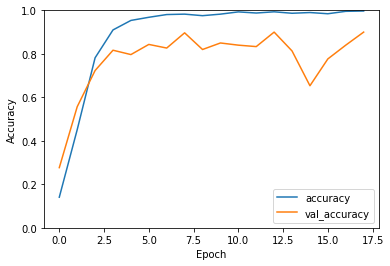

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testX,  testY, verbose=2)

Większa ilość czasu i umiejętności pomogłaby w osiągnięciu większej trafności walidacyjnej. Pomóc mógłby w tym generator danych, jednak wynik val_accuracy w granicach 0.8-0.9 jest zadowalający.